In [27]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

from PIL import Image

from mirror_extractor import MirrorExtractor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
! ls ../../data/

crossings_points.pkl
crossings_points.pkl:Zone.Identifier
crossings_points_IRCamM1T20250702_161000M.pkl
crossings_points_IRCamM1T20250702_161000M.pkl:Zone.Identifier
webcam_useful_image
webcam_useful_images-20251017T172853Z-1-001.zip
webcam_useful_images-20251017T172853Z-1-001.zip:Zone.Identifier


In [11]:
! ls ../../data/webcam_useful_image/webcam_useful_images/image_2023-01-01_1200.jpg


../../data/webcam_useful_image/webcam_useful_images/image_2023-01-01_1200.jpg


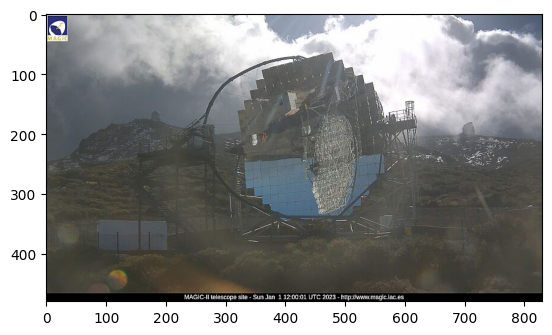

In [14]:
img_path = "../../data/webcam_useful_image/webcam_useful_images/image_2023-01-01_1200.jpg"
img = np.array(Image.open(img_path).convert('RGB'))

plt.imshow(img)

In [5]:
extractor = MirrorExtractor("../../data/crossings_points.pkl")


In [2]:
def extract_one_mirror_from_images(img_path_list, mirror_id, extractor):
    mirror_list = []
    for path in img_path_list:
        print(path)
        img = np.array(Image.open(path).convert('RGB'))
        x_coords, y_coords = extractor.get_coords(mirror_id)
        cropped = extractor.extract_polygon_region_cv2(img, x_coords, y_coords)
        mirror_list.append(cropped)
    return mirror_list

In [3]:
img_list = glob.glob("../../data/webcam_useful_image/webcam_useful_images/*.jpg")
img_list[:10]

['../../data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2023-01-04_1600.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-01-21_1600.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2023-01-05_1300.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-06_1400.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-01-28_1800.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1400.jpg']

../../data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2023-01-04_1600.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-01-21_1600.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2023-01-05_1300.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-06_1400.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-01-28_1800.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1400.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2023-06-11_1400.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2023-01-31_1700.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2023-0

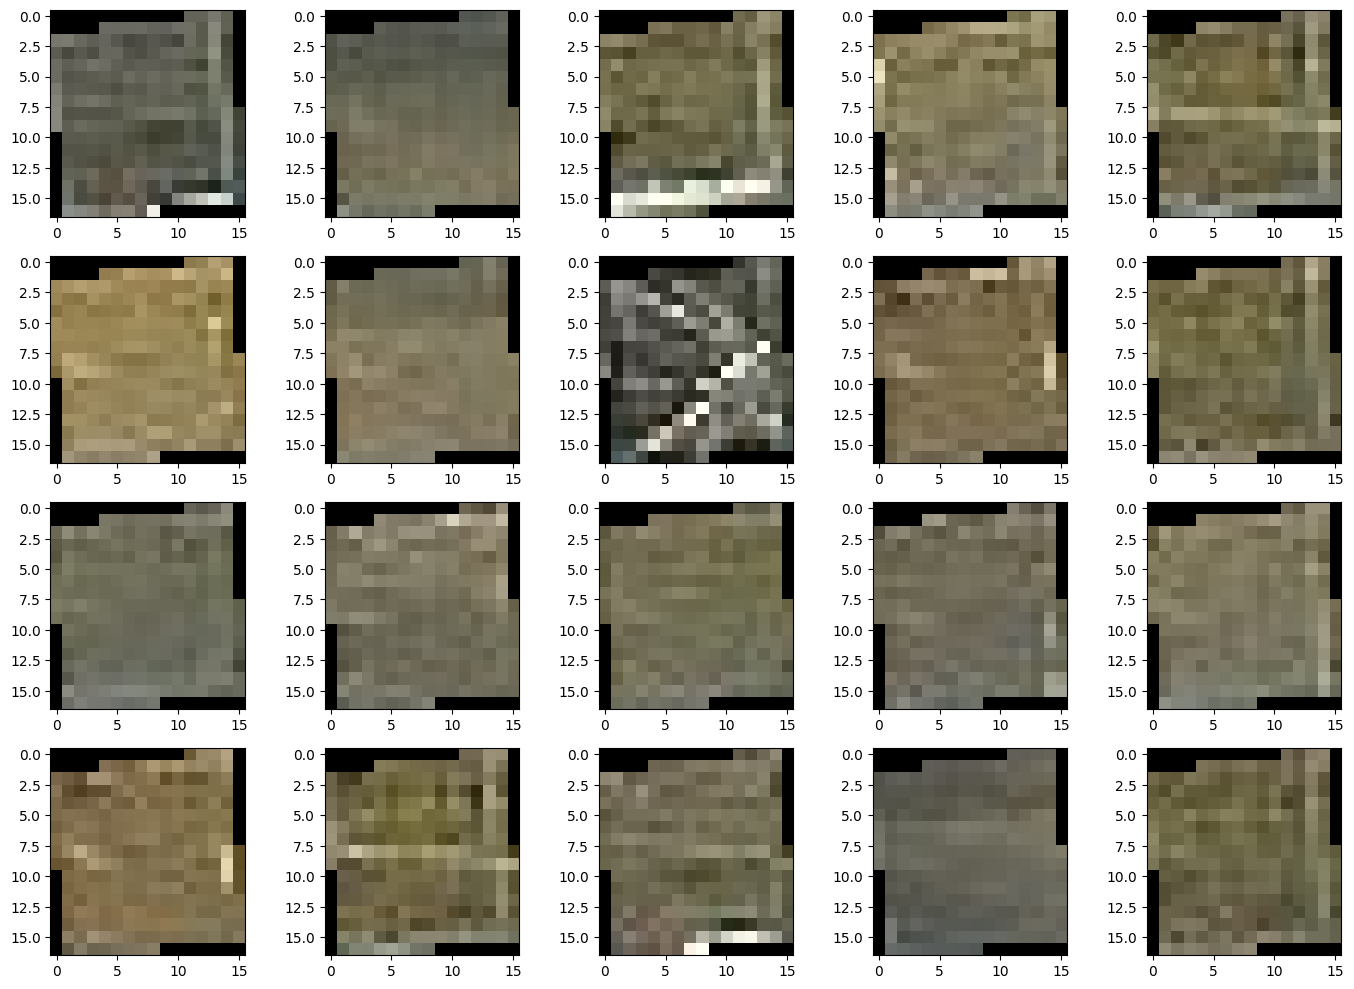

In [6]:
mirror_list = extract_one_mirror_from_images(img_list[:20], 155, extractor)

fig, ax = plt.subplots(4, 5, figsize=(14, 10))
axes = ax.flatten()
for i in range(20):
    axes[i].imshow(mirror_list[i])

plt.tight_layout()

In [29]:
mirror_list[2].shape

(17, 16, 3)

In [7]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_mirror_features(mirror_list):
    """
    Oblicza cechy dla każdego lustra
    """
    features = []
    
    for mirror in mirror_list:
        feature_dict = {}
        
        # 1. Statystyki podstawowe dla każdego kanału RGB
        for i, color in enumerate(['R', 'G', 'B']):
            feature_dict[f'{color}_mean'] = np.mean(mirror[:, :, i])
            feature_dict[f'{color}_std'] = np.std(mirror[:, :, i])
            feature_dict[f'{color}_median'] = np.median(mirror[:, :, i])
            feature_dict[f'{color}_min'] = np.min(mirror[:, :, i])
            feature_dict[f'{color}_max'] = np.max(mirror[:, :, i])
        
        # 2. Jasność ogólna
        feature_dict['brightness'] = np.mean(mirror)
        feature_dict['brightness_std'] = np.std(mirror)
        
        # 3. Kontrast
        feature_dict['contrast'] = np.std(mirror)
        
        # 4. Entropia (miara "chaotyczności")
        hist, _ = np.histogram(mirror.flatten(), bins=256, range=(0, 256))
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        feature_dict['entropy'] = -np.sum(hist * np.log2(hist))
        
        # 5. Dominujący kolor (RGB)
        feature_dict['dominant_R'] = np.percentile(mirror[:, :, 0], 75)
        feature_dict['dominant_G'] = np.percentile(mirror[:, :, 1], 75)
        feature_dict['dominant_B'] = np.percentile(mirror[:, :, 2], 75)
        
        # 6. Gradient (wykrywa krawędzie/wzory)
        gray = np.mean(mirror, axis=2)
        gradient_x = np.gradient(gray, axis=1)
        gradient_y = np.gradient(gray, axis=0)
        feature_dict['gradient_magnitude'] = np.mean(np.sqrt(gradient_x**2 + gradient_y**2))
        
        # 7. Liczba pikseli bardzo jasnych i bardzo ciemnych
        feature_dict['very_bright_ratio'] = np.sum(mirror > 200) / mirror.size
        feature_dict['very_dark_ratio'] = np.sum(mirror < 50) / mirror.size
        
        features.append(feature_dict)
    
    return features





In [12]:
mirror_features = compute_mirror_features(mirror_list)

In [28]:
df_mirror_features = pd.DataFrame(mirror_features)
df_mirror_features.head()

,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio
0,83.283088,40.356190,89.0,0,240,84.033088,40.672685,90.0,0,240,...,80.417892,39.918521,39.918521,5.981539,104.00,104.00,92.25,32.159925,0.009804,0.144608
1,91.084559,38.717256,103.0,0,141,89.816176,37.543544,102.0,0,145,...,85.182598,36.670629,36.670629,5.620396,116.00,111.25,91.00,22.208438,0.000000,0.136029
2,103.790441,54.760409,108.5,0,255,100.904412,54.603636,103.5,0,255,...,94.207108,54.659889,54.659889,6.482446,124.25,120.00,92.00,41.106740,0.057598,0.160539
3,114.441176,48.778425,127.0,0,236,108.297794,46.374311,120.5,0,228,...,102.115196,46.544323,46.544323,6.137859,140.00,132.25,105.25,34.613219,0.004902,0.136029
4,99.382353,44.779945,109.0,0,188,94.555147,43.334505,103.0,0,185,...,87.783088,43.664449,43.664449,6.349814,124.00,118.75,92.00,33.668188,0.000000,0.154412


In [29]:
df_mirror_features.describe()

,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio
count,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,100.711581,44.615346,111.625000,0.0,196.000000,95.677757,42.731289,105.600000,0.0,190.900000,...,90.415502,42.993165,42.993165,6.015369,123.437500,117.175000,93.037500,30.862030,0.007292,0.149449
std,11.593795,5.436724,14.784304,0.0,42.443771,8.143996,5.071837,10.762508,0.0,41.854258,...,7.436848,5.469440,5.469440,0.348471,12.297538,8.607333,7.084209,5.728194,0.014579,0.025839
min,83.283088,35.421055,82.000000,0.0,127.000000,83.875000,34.944874,83.000000,0.0,124.000000,...,80.417892,34.186603,34.186603,5.302218,104.000000,103.000000,81.000000,22.208438,0.000000,0.136029
25%,93.961397,40.372079,106.250000,0.0,159.500000,91.605699,39.358722,102.000000,0.0,149.500000,...,85.173407,38.938445,38.938445,5.765499,115.750000,113.000000,89.562500,27.523172,0.000000,0.136029
50%,99.375000,44.519670,109.000000,0.0,198.000000,94.683824,42.301400,104.250000,0.0,189.500000,...,89.745711,42.350883,42.350883,6.087789,123.000000,116.000000,92.125000,30.160336,0.000613,0.140931
75%,107.680147,46.945473,121.250000,0.0,231.500000,99.558824,43.796776,108.875000,0.0,218.250000,...,94.350490,45.186269,45.186269,6.231099,129.250000,120.062500,97.500000,33.325010,0.006127,0.151042
max,132.411765,54.760409,150.000000,0.0,255.000000,117.051471,54.603636,132.000000,0.0,255.000000,...,109.365196,54.659889,54.659889,6.680889,158.000000,140.000000,105.250000,46.430210,0.057598,0.251225


In [13]:
mirror_features[0]

{'R_mean': np.float64(83.28308823529412),
 'R_std': np.float64(40.35618994569967),
 'R_median': np.float64(89.0),
 'R_min': np.uint8(0),
 'R_max': np.uint8(240),
 'G_mean': np.float64(84.03308823529412),
 'G_std': np.float64(40.67268478379103),
 'G_median': np.float64(90.0),
 'G_min': np.uint8(0),
 'G_max': np.uint8(240),
 'B_mean': np.float64(73.9375),
 'B_std': np.float64(37.872169739913545),
 'B_median': np.float64(79.0),
 'B_min': np.uint8(0),
 'B_max': np.uint8(232),
 'brightness': np.float64(80.41789215686275),
 'brightness_std': np.float64(39.91852146988051),
 'contrast': np.float64(39.91852146988051),
 'entropy': np.float64(5.981538934906864),
 'dominant_R': np.float64(104.0),
 'dominant_G': np.float64(104.0),
 'dominant_B': np.float64(92.25),
 'gradient_magnitude': np.float64(32.15992544334488),
 'very_bright_ratio': np.float64(0.00980392156862745),
 'very_dark_ratio': np.float64(0.14460784313725492)}

In [16]:
features_names = list(mirror_features[0].keys())
X = np.array([[f[name] for name in features_name] for f in mirror_features])

In [17]:
X.shape

(20, 25)

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

outlier_scores = np.zeros(len(mirror_list))

In [50]:
z_scores = np.abs(stats.zscore(X_scaled, axis=0))
outlier_scores = np.mean(z_scores, axis=1)
outliers = outlier_scores > 2
outliers

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [20]:
X[:, 2]

array([ 89. , 103. , 108.5, 127. , 109. , 150. , 126. ,  82. , 121. ,
       108.5, 107. , 112. , 112. , 109. , 122. , 127. , 110.5, 108. ,
        97. , 104. ])

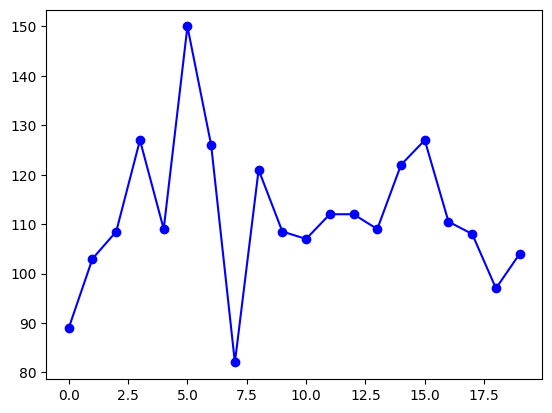

In [21]:
plt.plot(X[:, 2], 'bo-')

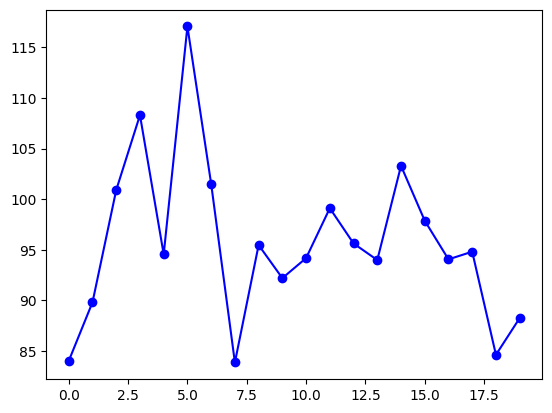

In [23]:
plt.plot(X[:, 5], 'bo-')


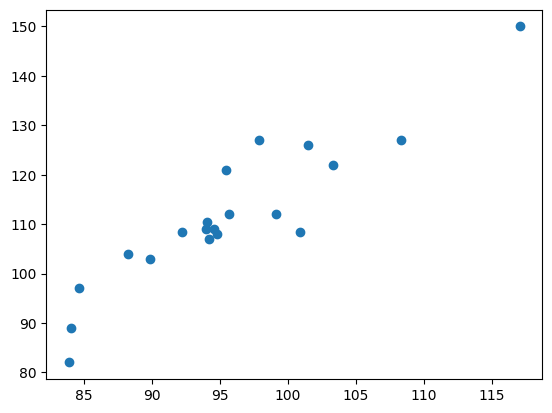

In [24]:
plt.scatter(X[:, 5], X[:, 2])
